In [1]:
import os

def count_files(folder, extensions):
    count = 0
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(extensions):
                count += 1
    return count

# Chemins (à adapter si nécessaire)
image_train_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\images\train\cats"
audio_train_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\train\cats"
spec_test_cats  = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\spectrograms\test\cats"

print("Images train (cats) :", count_files(image_train_cats, (".jpg",".jpeg",".png")))
print("Audios train (cats)  :", count_files(audio_train_cats, (".wav",)))
print("Spectrograms test (cats) :", count_files(spec_test_cats, (".png",)))


Images train (cats) : 4000
Audios train (cats)  : 427
Spectrograms test (cats) : 111


In [2]:
import pandas as pd

# Chargez votre mapping (par exemple pour le test)
mapping_csv = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df = pd.read_csv(mapping_csv)

print("Distribution des labels dans le mapping :")
print(df['label'].value_counts())


Distribution des labels dans le mapping :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


In [3]:
import pandas as pd

TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df_test = pd.read_csv(TEST_CSV)
print("Distribution des labels dans le mapping de test :")
print(df_test['label'].value_counts())


Distribution des labels dans le mapping de test :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


=== Vérification de la structure des dossiers ===
Images test (cats): 1000
Audios test (cats): 111
Spectrograms test (cats): 111

=== Distribution des labels dans le mapping de test ===
label
0    1000
1    1000
2     343
Name: count, dtype: int64

Nombre d'échantillons de test utilisés : 2343

🔄 Chargement du modèle fusionné...



✅ Modèle fusionné chargé.

🔄 Prédictions sur le jeu de test...
74/74 [==============================] - 2s 30ms/step

=== Rapport de classification ===
              precision    recall  f1-score   support

        Chat       0.83      0.99      0.90      1000
       Chien       0.84      0.96      0.90      1000
      Erreur       0.00      0.00      0.00       343

    accuracy                           0.83      2343
   macro avg       0.56      0.65      0.60      2343
weighted avg       0.71      0.83      0.77      2343



c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


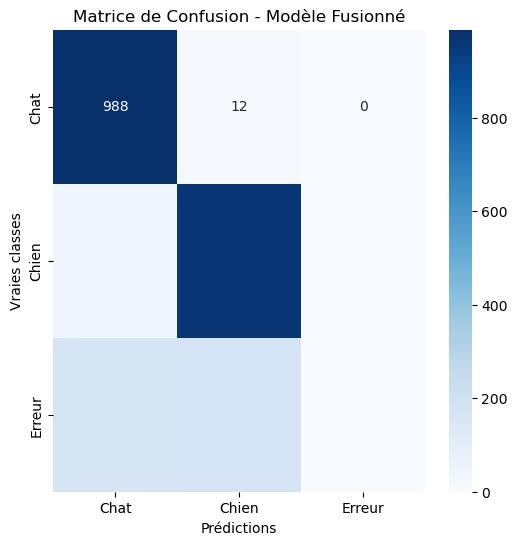

🎯 Accuracy du modèle fusionné sur le test: 83.27%


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ======= 1. Vérification de la structure des dossiers =======
def count_files(folder, extensions):
    count = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(extensions):
                count += 1
    return count

# Exemple pour les chats en test
image_dir_test_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\images\test\cats"
audio_dir_test_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\test\cats"
spec_dir_test_cats  = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\spectrograms\test\cats"

print("=== Vérification de la structure des dossiers ===")
print("Images test (cats):", count_files(image_dir_test_cats, (".jpg", ".jpeg", ".png")))
print("Audios test (cats):", count_files(audio_dir_test_cats, (".wav",)))
print("Spectrograms test (cats):", count_files(spec_dir_test_cats, (".png",)))
print("==============================================\n")

# ======= 2. Vérification du mapping de test =======
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df = pd.read_csv(TEST_CSV)
print("=== Distribution des labels dans le mapping de test ===")
print(df["label"].value_counts())
print("========================================================\n")

# ======= 3. Prétraitement des images et spectrogrammes =======
def preprocess_image(image_path):
    """Charge et prétraite une image en niveaux de gris (64x64, normalisée)."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Image non trouvée : {image_path}")
        return None
    img = cv2.resize(img, (64, 64)) / 255.0
    return img.reshape(64, 64, 1)

def preprocess_audio(audio_path):
    r"""
    Convertit le chemin d'un fichier audio en chemin vers le spectrogramme correspondant.
    On suppose que le fichier audio se trouve dans un chemin contenant "\cleaned\audio"
    et que le spectrogramme se trouve dans le même chemin avec "\spectrograms" à la place,
    et l'extension ".wav" remplacée par ".png".

    Exemple :
    Audio :  C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\test\cats\cat0012.wav
    Spec :  C:\Users\briac\Desktop\projet_3\data\data_fusion_model\spectrograms\test\cats\cat0012.png
    """
    spec_path = audio_path.replace(r"\cleaned\audio", r"\spectrograms").replace(".wav", ".png")
    if not os.path.exists(spec_path):
        print(f"❌ Spectrogramme non trouvé : {spec_path}")
        return None
    spec_img = cv2.imread(spec_path, cv2.IMREAD_GRAYSCALE)
    if spec_img is None:
        print(f"❌ Erreur lors du chargement du spectrogramme : {spec_path}")
        return None
    spec_img = cv2.resize(spec_img, (64, 64)) / 255.0
    return spec_img.reshape(64, 64, 1)

# Chargement du mapping de test et prétraitement
X_images, X_audio, y_true = [], [], []
for _, row in df.iterrows():
    image_path = row["image_path"]
    audio_path = row["audio_path"]
    if not os.path.exists(image_path):
        print(f"❌ Chemin image inexistant : {image_path}")
        continue
    if not os.path.exists(audio_path):
        print(f"❌ Chemin audio inexistant : {audio_path}")
        continue
    img = preprocess_image(image_path)
    aud = preprocess_audio(audio_path)
    if img is None or aud is None:
        continue
    X_images.append(img)
    X_audio.append(aud)
    y_true.append(int(row["label"]))

if len(X_images) == 0 or len(X_audio) == 0:
    print("❌ Aucun échantillon de test valide trouvé.")
    exit()

X_images = np.array(X_images)
X_audio = np.array(X_audio)
y_true = np.array(y_true)
print(f"Nombre d'échantillons de test utilisés : {X_images.shape[0]}\n")

# ======= 4. Chargement du modèle fusionné =======
# Utiliser le chemin absolu pour le modèle fusionné
FUSION_MODEL_PATH = r"C:\Users\briac\Desktop\projet_3\models\image_audio_fusion_model_v2.keras"
print("🔄 Chargement du modèle fusionné...")
fusion_model = tf.keras.models.load_model(FUSION_MODEL_PATH)
print("✅ Modèle fusionné chargé.\n")

# ======= 5. Prédictions =======
print("🔄 Prédictions sur le jeu de test...")
y_pred_probs = fusion_model.predict([X_images, X_audio])
y_pred = np.argmax(y_pred_probs, axis=1)

# ======= 6. Évaluation =======
label_names = {0: "Chat", 1: "Chien", 2: "Erreur"}
target_names = [label_names[0], label_names[1], label_names[2]]

print("\n=== Rapport de classification ===")
print(classification_report(y_true, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion - Modèle Fusionné")
plt.show()

accuracy = np.mean(y_pred == y_true) * 100
print(f"🎯 Accuracy du modèle fusionné sur le test: {accuracy:.2f}%")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier CSV du mapping de test
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df = pd.read_csv(TEST_CSV)

# Vérifier la distribution des labels
label_counts = df["label"].value_counts().sort_index()

# Affichage des résultats
print("🔍 Répartition des labels dans le jeu de test :")
print(label_counts)

# Visualisation
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues")
plt.xticks([0,1,2], ["Chat", "Chien", "Erreur"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des labels dans le jeu de test")
plt.show()
